In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option("display.max_rows", None)
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.float_format = '{:,.2f}'.format

C:\Users\alexandre\AppData\Local\Temp\ipykernel_24988\1748361488.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
df = pd.read_excel('./ExportacaoVinhos.xlsx')
df.head()

,Pais,2008_KG,2008_USD,2009_KG,2009_USD,2010_KG,2010_USD,2011_KG,2011_USD,2012_KG,...,2018_KG,2018_USD,2019_KG,2019_USD,2020_KG,2020_USD,2021_KG,2021_USD,2022_KG,2022_USD
0,Afeganistão,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11,46,0,0
1,África do Sul,0,0,0,0,0,0,0,0,0,...,0,0,26,95,4,21,0,0,0,0
2,"Alemanha, República Democrática",265742,429970,225086,393482,27715,138666,36070,144150,8189,...,10794,45382,3660,25467,6261,32605,2698,6741,7630,45367
3,Angola,25721,71083,54786,84235,33557,189891,13889,69001,2833,...,477,709,345,1065,0,0,0,0,4068,4761
4,Anguilla,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_melted = pd.melt(df, id_vars=['Pais'], var_name='Ano e Valor', value_name='Quantidade')
df_melted[['Ano', 'Valor']] = df_melted['Ano e Valor'].str.split('_', expand=True)
df_exportacao = df_melted.pivot(index=['Pais', 'Ano'], columns='Valor', values='Quantidade').reset_index()
df_exportacao.columns.name = None 
df_exportacao = df_exportacao.rename(columns={'Litros': 'Litros', 'USD': 'USD'})
df_exportacao.tail()

,Pais,Ano,KG,USD
1915,Áustria,2018,0,0
1916,Áustria,2019,0,0
1917,Áustria,2020,0,0
1918,Áustria,2021,0,0
1919,Áustria,2022,6,212


In [4]:
df_exportacao['Ano'] = pd.to_datetime(df_exportacao['Ano'], format='%Y')


In [5]:
df_exportacao['Origem'] = 'Brasil'
df_exportacao.head()

,Pais,Ano,KG,USD,Origem
0,Afeganistão,2008-01-01,0,0,Brasil
1,Afeganistão,2009-01-01,0,0,Brasil
2,Afeganistão,2010-01-01,0,0,Brasil
3,Afeganistão,2011-01-01,0,0,Brasil
4,Afeganistão,2012-01-01,0,0,Brasil


In [6]:
df_exportacao.rename(columns={'Pais': 'Destino'}, inplace=True)
df_exportacao.rename(columns={'KG': 'Litros'}, inplace=True)
df_exportacao.head()

,Destino,Ano,Litros,USD,Origem
0,Afeganistão,2008-01-01,0,0,Brasil
1,Afeganistão,2009-01-01,0,0,Brasil
2,Afeganistão,2010-01-01,0,0,Brasil
3,Afeganistão,2011-01-01,0,0,Brasil
4,Afeganistão,2012-01-01,0,0,Brasil


In [7]:
df_exportacao.shape

(1920, 5)

In [8]:
df_exportacao.describe()

,Ano,Litros,USD
count,1920,"1,920.00","1,920.00"
mean,2015-01-01 03:12:00,"45,824.18","58,668.91"
min,2008-01-01 00:00:00,0.00,0.00
25%,2011-01-01 00:00:00,0.00,0.00
50%,2015-01-01 00:00:00,0.00,0.00
75%,2019-01-01 00:00:00,"1,006.25","4,000.50"
max,2022-01-01 00:00:00,"21,912,914.00","14,795,694.00"
std,NaN,"598,815.48","498,786.26"


In [9]:
df_exportacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Destino  1920 non-null   object        
 1   Ano      1920 non-null   datetime64[ns]
 2   Litros   1920 non-null   int64         
 3   USD      1920 non-null   int64         
 4   Origem   1920 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 75.1+ KB


In [10]:
df_exportacao.set_index('Destino', inplace=True)
df_exportacao.drop(['Brasil'], inplace=True)
df_exportacao.head()

,Ano,Litros,USD,Origem
Destino,,,,
Afeganistão,2008-01-01,0,0,Brasil
Afeganistão,2009-01-01,0,0,Brasil
Afeganistão,2010-01-01,0,0,Brasil
Afeganistão,2011-01-01,0,0,Brasil
Afeganistão,2012-01-01,0,0,Brasil


In [11]:
total_kg = df_exportacao.groupby(['Destino']).sum('Litros').sort_values(by='Litros', ascending=False)
paises_remover = total_kg[total_kg['Litros'] == 0].index
paises_remover

Index(['Iraque', 'Costa do Marfim', 'Jamaica', 'Tanzânia', 'Ilhas Virgens',
       'República Dominicana', 'Tunísia', 'Líbano', 'Senegal', 'Anguilla',
       'Porto Rico'],
      dtype='object', name='Destino')

In [12]:
df_exportacao.drop(paises_remover, inplace=True, errors='ignore')

In [13]:
df_exportacao.index.nunique()

116

## Nos últimos 15 anos nós exportamos vinho para 116 Países.

In [14]:
df_total_por_pais = df_exportacao.groupby('Destino').sum(['Litros','USD']).sort_values('Litros', ascending=False)
top_10_consumidores = df_total_por_pais.head(10).index
top_10_consumidores

Index(['Rússia', 'Paraguai', 'Estados Unidos', 'China', 'Espanha', 'Haiti',
       'Reino Unido', 'Países Baixos', 'Japão',
       'Alemanha, República Democrática'],
      dtype='object', name='Destino')

In [15]:
df_total_por_pais.head(10)


,Litros,USD
Destino,,
Rússia,39029799,25504484
Paraguai,29214770,38719031
Estados Unidos,3563355,9684567
China,2509458,4746525
Espanha,1993000,3808552
Haiti,1791603,2327208
Reino Unido,1239551,4711464
Países Baixos,1236154,3791611
Japão,1181692,2377716


#### Os 10 Países que mais importam vinhos Brasileiros são: Rússia, Paraguai, Estados Unidos, China, Espanha, Haiti,Reino Unido, Países Baixos, Japão e Alemanha.

In [16]:
df_exportacao.reset_index(inplace=True)
df_exportacao = df_exportacao[['Ano', 'Destino', 'Origem', 'Litros', 'USD']]
df_exportacao.head()

,Ano,Destino,Origem,Litros,USD
0,2008-01-01,Afeganistão,Brasil,0,0
1,2009-01-01,Afeganistão,Brasil,0,0
2,2010-01-01,Afeganistão,Brasil,0,0
3,2011-01-01,Afeganistão,Brasil,0,0
4,2012-01-01,Afeganistão,Brasil,0,0


In [20]:
df_total_por_pais = df_exportacao.groupby(['Origem','Destino']).sum(['Litros','USD']).sort_values('Litros', ascending=False)
df_total_por_pais.reset_index(inplace=True)
df_total_por_pais.head()

,Origem,Destino,Litros,USD
0,Brasil,Rússia,39029799,25504484
1,Brasil,Paraguai,29214770,38719031
2,Brasil,Estados Unidos,3563355,9684567
3,Brasil,China,2509458,4746525
4,Brasil,Espanha,1993000,3808552


1 . Quais são os 5 principais destinos em termos de volume de litros e valor em USD?
2 . Qual é o país para o qual o Brasil exporta a menor quantidade de litros?
3 . Qual é a média e a mediana do volume de litros exportados para todos os destinos?
4 . Qual é a média e a mediana do valor em USD exportado para todos os destinos?
5 . Qual é o preço médio por litro para cada destino (USD por litro)?

In [27]:
top5_litros = df_total_por_pais.sort_values(by="Litros", ascending=False).head(5)[['Destino', 'Litros']]
top5_usd = df_total_por_pais.sort_values(by="USD", ascending=False).head(5)[['Destino', 'USD']]
min_litros = df_total_por_pais[df_total_por_pais["Litros"] == df_total_por_pais["Litros"].min()][['Destino', 'Litros']]
media_litros = df_total_por_pais["Litros"].mean()
mediana_litros = df_total_por_pais["Litros"].median()
media_usd = df_total_por_pais["USD"].mean()
mediana_usd = df_total_por_pais["USD"].median()
df_total_por_pais['USD_por_Litro'] = df_total_por_pais['USD'] / df_total_por_pais['Litros']
preco_medio_por_litro = df_total_por_pais[['Destino', 'USD_por_Litro']]

print("Top 5 países que mais importaram vinho do Brasil em Litros:")
print(top5_litros)
print("Top 5 países que mais importaram vinho do Brasil em USD:")
print(top5_usd)
print("País que menos importou vinho do Brasil em Litros:")
print(min_litros)
print("Média de Litros importados:")
print(media_litros)
print("Mediana de Litros importados:")
print(mediana_litros)
print("Média de USD importados:")
print(media_usd)
print("Mediana de USD importados:")
print(mediana_usd)
print("Preço médio por Litro:")
print(preco_medio_por_litro.head())


Top 5 países que mais importaram vinho do Brasil em Litros:
          Destino    Litros
0          Rússia  39029799
1        Paraguai  29214770
2  Estados Unidos   3563355
3           China   2509458
4         Espanha   1993000
Top 5 países que mais importaram vinho do Brasil em USD:
          Destino       USD
1        Paraguai  38719031
0          Rússia  25504484
2  Estados Unidos   9684567
3           China   4746525
6     Reino Unido   4711464
País que menos importou vinho do Brasil em Litros:
    Destino  Litros
115  Tuvalu       2
Média de Litros importados:
758447.3879310344
Mediana de Litros importados:
11212.0
Média de USD importados:
971063.0862068966
Mediana de USD importados:
34593.5
Preço médio por Litro:
          Destino  USD_por_Litro
0          Rússia           0.65
1        Paraguai           1.33
2  Estados Unidos           2.72
3           China           1.89
4         Espanha           1.91


1. **Top 5 países importadores em litros**: 
   - Rússia é o maior importador de vinho brasileiro em termos de volume, seguida por Paraguai, Estados Unidos, China e Espanha.

2. **Top 5 países importadores em USD**: 
   - Paraguai é o maior importador em termos de valor, gastando mais de 38 milhões de dólares, mesmo tendo um volume menor em comparação com a Rússia. Isso indica que o vinho exportado para o Paraguai pode ser de um segmento mais caro ou de maior qualidade. 
   - A Rússia, apesar de ser o maior importador em volume, ocupa o segundo lugar em termos de valor, o que sugere que eles podem estar comprando vinhos mais baratos ou aproveitando descontos por comprar em maior volume.
   - Estados Unidos, China e Reino Unido completam o top 5 em valor. Vale notar que o Reino Unido não aparece no top 5 em termos de volume, o que indica que eles podem estar comprando vinhos de segmento mais alto ou premium.

3. **País que menos importou em litros**: 
   - Tuvalu é o país que menos importou vinho brasileiro, com apenas 2 litros. Isso pode ser devido ao seu pequeno tamanho e população, ou simplesmente uma demanda muito limitada por vinhos brasileiros.

4. **Médias e Medianas**: 
   - A média de litros importados é de 758,447 litros, enquanto a mediana é de 11,212 litros. A grande diferença entre a média e a mediana sugere que existem alguns países que importam quantidades muito grandes, puxando a média para cima.
   - Em termos de USD, a média é de 971,063 USD, e a mediana é de 34,593.5 USD. Novamente, a diferença sugere que alguns países gastam quantias muito maiores que outros.

5. **Preço médio por litro**: 
   - O preço por litro dá uma ideia do segmento ou qualidade do vinho exportado para diferentes países. 
   - Estados Unidos, com 2.72 USD por litro, é o que paga o preço mais alto entre os top 5, o que sugere uma preferência por vinhos de maior qualidade ou segmento mais alto.
   - Rússia paga o menor preço por litro, 0.65 USD, o que sugere que eles podem estar focados em vinhos de segmento mais baixo ou podem estar aproveitando descontos por comprar em grande volume.

**Conclusão**: A análise dos dados revela diversas nuances no mercado de exportação de vinhos do Brasil. Por exemplo, enquanto a Rússia é o maior importador em volume, o Paraguai lidera em termos de valor, indicando diferentes preferências e estratégias de mercado entre os países. Além disso, o preço médio por litro oferece insights sobre a qualidade ou segmento do vinho que é mais popular em diferentes nações.

In [ ]:
df_total_por_pais.head()

## importando mais 2 csv para comparar producao vs exportacao

In [28]:
df_total_exportado_por_ano = pd.read_csv('./ExpVinhoTotalAno.csv', sep=';')
df_total_exportado_por_ano.head()

,Anos,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Litros Exportados,10346323,25514198,1280574,1214834,5775376,9149059,2324029,1198479,1786549,2889572,3856162,3152873,4409717,8058704,7025983


In [29]:
df_total_produzido_por_ano = pd.read_csv('./ProducaoTotalAno.csv', sep=';')
df_total_produzido_por_ano.head()

,Anos,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Total Produzido,334841312,245318774,220073693,305439220,257977767,242686752,234637437,247457542,104389641,299553057,257082856,182245159,156717100,217374993,242543407


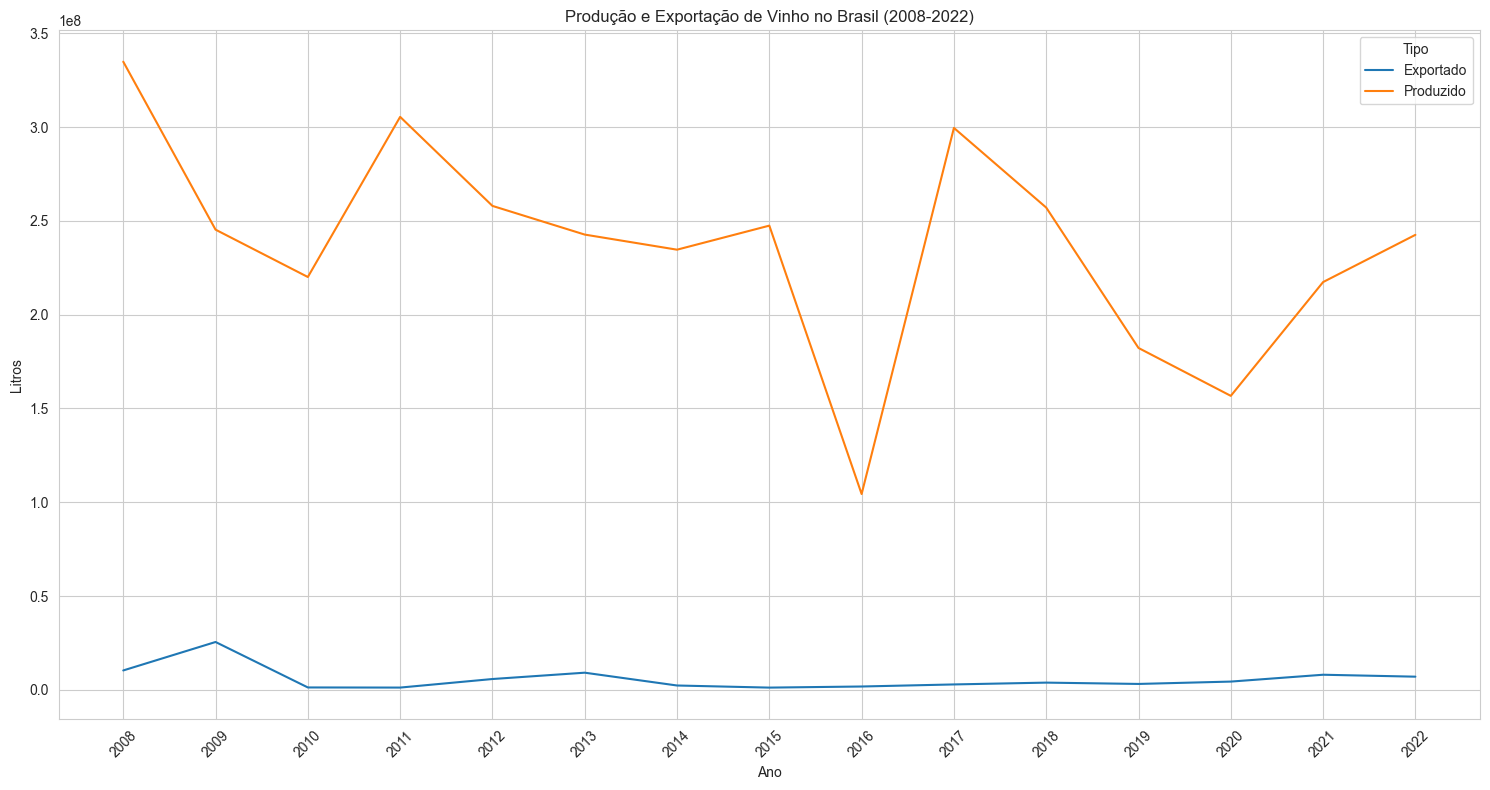

In [30]:
# Transformando os dados para o formato longo
df_exportado = df_total_exportado_por_ano.melt(id_vars=['Anos'], value_name='Litros', var_name='Ano')
df_exportado['Tipo'] = 'Exportado'

df_produzido = df_total_produzido_por_ano.melt(id_vars=['Anos'], value_name='Litros', var_name='Ano')
df_produzido['Tipo'] = 'Produzido'

# Concatenando os dois DataFrames
df_final = pd.concat([df_exportado, df_produzido])

# Configurando o tamanho e o estilo do gráfico
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Criando o gráfico de linha
sns.lineplot(data=df_final, x='Ano', y='Litros', hue='Tipo')

# Configurando o título e os rótulos dos eixos
plt.title("Produção e Exportação de Vinho no Brasil (2008-2022)")
plt.xlabel("Ano")
plt.ylabel("Litros")
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrando o gráfico
plt.show()

In [18]:
# df_total_por_pais.to_excel('./ExportacaoVinhosTotais.xlsx', index=False)

In [19]:
# # import the library
# import dtale

# # open the analysis in browser
# dtale.show(df_exportacao).open_browser()